Análise dos Dados Abertos da Câmara dos Deputados
Neste notebook:

- Consulta aos dados no datalake da Base dos Dados;
- Tratamento dos dados para construir os indicadores de produção legislativa propostos pelo Legisla Brasil. Acesse [aqui](https://indice.legislabrasil.org/metodologia)
- Construção dos indicadores
- Análise dos dados (por tamanho de partido, bancada e gênero)

In [1]:
import basedosdados as bd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Consultas

- Dividimos a consulta para reproduzir o indicador de produção legislativa do Legisla Brasil em duas partes. Na primeira pegamos as informações sobre as proposições e na segunda sobre a ppresença em plenário durante as sessões deliberativas.

## Produção legislativa (parte 1)

- Apresentação de projetos
- Protagonismo de autoria
- Relevância das autorias
- Nº de votos em separado apresentados
- Nº de substitutivos apresentados
- Nº de relatorias apresentadas
- Nº de emendas de plenário


In [2]:
query_prod_leg1 = """
SELECT autor.id_proposicao, #proposicao_autor
autor.id_deputado,
autor.nome_autor,
autor.sigla_partido,
autor.sigla_uf_autor, 
autor.ordem_assinatura,
autor.proponente,
microdados.tipo, #proposicao_microdados
microdados.sigla,
microdados.ementa, 
tema_prop.tema,
dep.sexo # proposicao_tema
FROM `basedosdados.br_camara_dados_abertos.proposicao_autor` as autor
LEFT JOIN `basedosdados.br_camara_dados_abertos.proposicao_microdados` as microdados 
ON autor.id_proposicao = microdados.id_proposicao
LEFT JOIN `basedosdados.br_camara_dados_abertos.proposicao_tema` as tema_prop
ON autor.id_proposicao = tema_prop.id_proposicao
LEFT JOIN `basedosdados.br_camara_dados_abertos.deputado` dep
ON autor.id_deputado = dep.id_deputado
WHERE microdados.data >= '2023-02-02' 
AND autor.id_deputado IS NOT NULL
"""
df_prop = bd.read_sql(query_prod_leg1, billing_project_id = 'Insira seu billing ID') # Lembrando que aqui é preciso ter um projeto no Google Cloud.
# É só acessar com a sua conta Google, criar um projeto e acessar as informações do projeto. Em inglês é o "Project ID" (é o que se usa como billing ID)

Downloading: 100%|██████████████████| 163901/163901 [00:43<00:00, 3735.87rows/s]


In [3]:
df_prop.head()

,id_proposicao,id_deputado,nome_autor,sigla_partido,sigla_uf_autor,ordem_assinatura,proponente,tipo,sigla,ementa,tema,sexo
0,2395635,220552,Zucco,REPUBLIC,RS,26,0,Recurso contra apreciação conclusiva de comiss...,REC,Recurso contra a tramitação conclusiva do Proj...,NaN,Masculino
1,2373713,220552,Zucco,REPUBLIC,RS,9,0,Requerimento de Inclusão de Matéria na Ordem d...,RPD,Requerimento de Inclusão de Matéria na Ordem d...,NaN,Masculino
2,2374385,220552,Zucco,REPUBLIC,RS,43,0,Requerimento de Criação de Frente Parlamentar,REQ,"Requer, nos termos regimentais, o registro da ...",NaN,Masculino
3,2373388,220552,Zucco,REPUBLIC,RS,189,0,Requerimento de Criação de Frente Parlamentar,REQ,Requer a criação da Frente Parlamentar Mista E...,NaN,Masculino
4,2391979,220552,Zucco,REPUBLIC,RS,81,0,Requerimento de Urgência (Art. 155 do RICD),REQ,Requer urgência para a apreciação do Projeto d...,NaN,Masculino


In [4]:
df_prop.shape

(163901, 12)

## Produção Legislativa (parte 2)

- Nº de presença em Plenário

In [10]:
query_prod_leg2 = """
SELECT evento_dep.id_evento, id_deputado, tipo, evento_dep.data_inicio
FROM  `basedosdados.br_camara_dados_abertos.evento_presenca_deputado` evento_dep
LEFT JOIN `basedosdados.br_camara_dados_abertos.evento` evento
ON evento_dep.id_evento = evento.id_evento
WHERE tipo = "Sessão Deliberativa" AND evento_dep.data_inicio >= '2023-02-02'
"""
df_presenca = bd.read_sql(query_prod_leg2, billing_project_id = 'cursopython-396323')

Downloading: 100%|███████████████████| 45674/45674 [00:02<00:00, 16621.68rows/s]


In [6]:
df_presenca.head()

,id_evento,id_deputado,tipo,data_inicio
0,67551,220579,Sessão Deliberativa,2023-04-11
1,67551,219585,Sessão Deliberativa,2023-04-11
2,67551,204367,Sessão Deliberativa,2023-04-11
3,67551,220601,Sessão Deliberativa,2023-04-11
4,67551,220564,Sessão Deliberativa,2023-04-11


# Tratamento dos dados

## Subset sem valores duplicados de proposição

In [8]:
# Filtro global
df_prop = df_prop[df_prop['tipo'] != 'Emenda de Plenário à MPV (Ato Conjunto 1/20)']

In [9]:
# Subset com valores únicos de proposição
df_unicos = df_prop.drop_duplicates(subset=['id_deputado', 'id_proposicao'])

In [10]:
# Comparação do tamanho dos dfs
n1 = len(pd.unique(df_prop['id_deputado']))
n2 = len(pd.unique(df_unicos['id_deputado']))
n3 = len(pd.unique(df_presenca['id_deputado']))

print(n1, n2, n3)

551 551 552


## Categorias

Utilizar as categorias (e critérios) do Legisla Brasil

- Em primeiro lugar, vamos utilizar um df específico para a contagem de projetos, para garantir que não vamos contar valores duplicados (um projeto pode ter mais de um tema ou ementa);
- Vamos criar subsets para cada uma das categorias para depois juntar todas as contagens e informações de sexo, UF e partido;

### Relevância das proposições

* Utiliza o df_prop

- Relevância das autorias: a partir da ementa e tema das proposições, alguns termos identificam proposições consideradas de baixa relevância (como nomeação de ruas, datas comemorativas etc.).
- Termos levados em consideração: ementa = hora|dia|Dia|semana|Semana|Mês|ano|data|festa|calendario|calendário|titulo|título|prêmio|medalha|nome|galeria|ponte|ferrovia|estrada| aeroporto|rotatória|honorário
tema = Homenagens e Datas Comemorativas

Consideramos todas as proposições

In [11]:
# Termos para a coluna 'ementa'
termos_ementa = r"hora|dia|Dia|semana|Semana|Mês|ano|data|festa|calendario|calendário|titulo|título|prêmio|medalha|nome|galeria|ponte|ferrovia|estrada|aeroporto|rotatória|honorário"

# Termo para a coluna 'tema'
termo_tema = r"Homenagens e Datas Comemorativas"

# Criar colunas auxiliares para identificar linhas que contêm os termos
df_prop['termos_ementa'] = df_prop['ementa'].str.contains(termos_ementa, case=False, na=False)
df_prop['termo_tema'] = df_prop['tema'].str.contains(termo_tema, case=False, na=False)

# Agrupar por 'id' e contar os casos
relevancia = df_prop.groupby('id_deputado').agg(
    termos_ementa_count=('termos_ementa', 'sum'), #padronizar essa nomeação depois
    termo_tema_count=('termo_tema', 'sum'),
    total=('id_deputado', 'size')
)

In [12]:
# Calcular os casos que não contêm os termos
relevancia['total_com_termos'] = relevancia['termos_ementa_count'] + relevancia['termo_tema_count']
relevancia['total_sem_termos'] = relevancia['total'] - relevancia['total_com_termos']

In [13]:
relevancia.head()

,termos_ementa_count,termo_tema_count,total,total_com_termos,total_sem_termos
id_deputado,,,,,
62881,34,1,297,35,262
66385,20,0,106,20,86
66828,67,1,373,68,305
69871,26,1,429,27,402
72442,103,1,538,104,434


### Frequência de proposições de cada deputado(a)

* Utiliza o df_unicos

- Apresentação de projetos: sigla = PDL, PEC, PL, PLP, PLV
- Número de votos em separado: sigla = VTS
- Substitutivos: sigla = SBT
- Número de relatorias apresentadas: (siglaTipo == "PRL")
- Emendas de plenário: sigla = EMP e EMR (com exceção da Emenda de Plenário à MPV (Ato Conjunto 1/20))

"sigla" se refere à coluna correspondente no nosso dataframe e identifica os diferentes tipos de proposição apresentados

In [14]:
# Definindo a para calcular as frequências
def count_values(group, values):
    return sum(group.isin(values))

# Lista de conjuntos de valores e nomes dos novos DataFrames
valores_list = [
    (['PDL', 'PEC', 'PL', 'PLP', 'PLV'], 'projeto'),
    (['VTS'], 'voto_separado'),
    (['SBT'], 'substitutivo'),
    (['PRL'], 'relatoria'),
    (['EMP', 'EMR'], 'emenda')
]

# Dicionário para armazenar os novos DataFrames
dfs_resultantes = {}

# Aplicando a função para cada conjunto de valores e criando novos DataFrames
for valores, df_name in valores_list:
    df_result = df_unicos.groupby(['id_deputado'])['sigla'].apply(lambda x: count_values(x, valores)).reset_index(name='contagem_valores')
    dfs_resultantes[df_name] = df_result

# Exibindo os DataFrames resultantes
for name, df in dfs_resultantes.items():
    print(f"\n{name}:\n{df}")


projeto:
     id_deputado  contagem_valores
0          62881                11
1          66385                13
2          66828                11
3          69871                19
4          72442                24
..           ...               ...
546       226179                 6
547       226410                10
548       226553                 4
549       226708                 3
550       226837                 6

[551 rows x 2 columns]

voto_separado:
     id_deputado  contagem_valores
0          62881                 0
1          66385                 0
2          66828                 0
3          69871                 0
4          72442                 0
..           ...               ...
546       226179                 0
547       226410                 0
548       226553                 0
549       226708                 0
550       226837                 0

[551 rows x 2 columns]

substitutivo:
     id_deputado  contagem_valores
0          62881                 0
1

In [15]:
# Criando DataFrames separados a partir do dicionário criado acima
for df_name, df in dfs_resultantes.items():
    globals()[df_name] = df

In [16]:
projeto.shape

(551, 2)

In [17]:
# Mudar o nome das colunas de frequencia
projeto = projeto.rename(columns={'contagem_valores': 'total_projeto'})
voto_separado = voto_separado.rename(columns={'contagem_valores': 'total_voto_separado'})
substitutivo = substitutivo.rename(columns={'contagem_valores': 'total_substitutivo'})
relatoria = relatoria.rename(columns={'contagem_valores': 'total_relatoria'})
emenda = emenda.rename(columns={'contagem_valores': 'total_emenda'})

In [18]:
print(emenda)

     id_deputado  total_emenda
0          62881             3
1          66385             2
2          66828             2
3          69871            11
4          72442            26
..           ...           ...
546       226179             0
547       226410             0
548       226553             0
549       226708             0
550       226837             0

[551 rows x 2 columns]


### Protagonismo de autoria

- Utiliza o df_unicos
- Indica os casos em que os deputados(as) foram os principais proponentes. Casos em que a ordem_assinatura e proponente são iguais a 1.

In [19]:
# Criar uma coluna auxiliar que indica se ambas as colunas têm o valor 1
df_unicos['protagonismo'] = ((df_unicos['ordem_assinatura'] == 1) & (df_unicos['proponente'] == 1)).astype(int)

# Agrupar pelos valores desejados (neste exemplo, por 'id') e calcular a soma da coluna auxiliar
protagonismo = df_unicos.groupby('id_deputado')['protagonismo'].sum().reset_index(name='soma_prot')

In [18]:
protagonismo.shape

(551, 2)

### Presença em plenário

- Presença em plenário durante as sessões

In [20]:
presenca = df_presenca.groupby(['id_deputado'])['id_evento'].count().reset_index(name='total_presenca')

In [20]:
presenca.head()

,id_deputado,total_presenca
0,62881,88
1,66385,90
2,66828,79
3,69871,96
4,72442,87


In [26]:
presenca.shape

(552, 2)

## Construindo a tabela da análise

- Vamos juntar no mesmo DataFrame todas as informações que juntamos até agora, e em seguida acrescentar as informações de sexo, partido e UF dos(as) deputados(as).

In [21]:
# Juntar os DataFrames com base na chave comum
dfs = [relevancia, projeto, voto_separado, substitutivo, relatoria, emenda, protagonismo, presenca]

# Inicializar com o primeiro DataFrame
prod_leg = relevancia

# Fazer merge sucessivo com os outros DataFrames
for df in dfs[1:]:
    prod_leg = prod_leg.merge(df, on='id_deputado', how='outer')

print(prod_leg)

     id_deputado  termos_ementa_count  termo_tema_count  total  \
0          62881                 34.0               1.0  297.0   
1          66385                 20.0               0.0  106.0   
2          66828                 67.0               1.0  373.0   
3          69871                 26.0               1.0  429.0   
4          72442                103.0               1.0  538.0   
..           ...                  ...               ...    ...   
555       163321                  NaN               NaN    NaN   
556       178886                  NaN               NaN    NaN   
557       204433                  NaN               NaN    NaN   
558       204503                  NaN               NaN    NaN   
559       220637                  NaN               NaN    NaN   

     total_com_termos  total_sem_termos  total_projeto  total_voto_separado  \
0                35.0             262.0           11.0                  0.0   
1                20.0              86.0          

### Acrescentando informações de nome, sexo, partido e UF

In [22]:
# Remover duplicatas com base na chave comum (mantendo a primeira ocorrência)
df_prop_unique = df_prop.drop_duplicates(subset='id_deputado', keep='first')

# Selecionar apenas algumas colunas do segundo DataFrame
colunas = ['id_deputado', 'nome_autor', 'sigla_partido', 'sigla_uf_autor', 'sexo']  # Colunas que você quer adicionar
df_prop_subset = df_prop_unique[colunas]

In [23]:
# Realizar o left join
prod_leg_final = prod_leg.merge(df_prop_subset, on='id_deputado', how='left')

# Exibir o DataFrame combinado
print("\nDataFrame combinado:")
print(prod_leg_final)


DataFrame combinado:
     id_deputado  termos_ementa_count  termo_tema_count  total  \
0          62881                 34.0               1.0  297.0   
1          66385                 20.0               0.0  106.0   
2          66828                 67.0               1.0  373.0   
3          69871                 26.0               1.0  429.0   
4          72442                103.0               1.0  538.0   
..           ...                  ...               ...    ...   
555       163321                  NaN               NaN    NaN   
556       178886                  NaN               NaN    NaN   
557       204433                  NaN               NaN    NaN   
558       204503                  NaN               NaN    NaN   
559       220637                  NaN               NaN    NaN   

     total_com_termos  total_sem_termos  total_projeto  total_voto_separado  \
0                35.0             262.0           11.0                  0.0   
1                20.0      

In [24]:
prod_leg_final.shape

(560, 17)

In [4]:
# Vamos remover e reordenar as colunas
prod_leg_final.drop(['termos_ementa_count', 'termo_tema_count', 'total', 'total_com_termos'], axis=1)

cols = ['id_deputado', 'nome_autor', 'sigla_partido', 'sigla_uf_autor', 'sexo', 'total_sem_termos', 'total_projeto', 'total_voto_separado', 'total_substitutivo', 'total_relatoria', 'total_emenda', 'soma_prot', 'total_presenca']
prod_leg_final = prod_leg_final[cols]

# Cálculo dos indicadores

- Construção dos indicadores com base no código fonte do Legisla Brasil. Veja [aqui](https://github.com/legislabr/indice-indicadores/blob/master/script.py).

In [16]:
# Removendo NAs
prod_leg_final = prod_leg_final.fillna(0)

In [17]:
# Função para calcular os scores (método de Sturges após remoção de outliers da distribuição para cada variável)

def calculate_outliers(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return [x for x in column if lower_limit <= x <= upper_limit]

def calculate_indicator(column):
    filtered_data = calculate_outliers(column)
    zero_indices = [i for i, x in enumerate(column) if x == 0]
    count = len([x for x in filtered_data if x > 0])
    num_classes = int(np.ceil(1 + 3.332 * np.log10(count))) if count > 0 else 0

    if num_classes <= 0:
        return [0 if x in filtered_data else 1 for x in column]
    
    min_value = min(filtered_data)
    max_value = max(filtered_data)
    bins = np.linspace(min_value, max_value, num_classes)
    bins = np.insert(bins, 0, -np.inf)
    bins[-1] = np.inf
    classes = np.digitize(column, bins, right=True)
    posicao_classe = classes / num_classes

    return [round(x, 2) if i not in zero_indices else 0 for i, x in enumerate(posicao_classe)]

def calculate_indicators(df, columns):
    for col in columns:
        df[col + '_score'] = calculate_indicator(df[col].astype(float))

def calculate_score_final(df, score_columns):
    df['score_final'] = df[score_columns].mean(axis=1).round(2)

In [18]:
# Vamos especficar as colunas que serão processadas
columns_to_process = ['total_sem_termos', 'total_projeto', 'total_voto_separado', 'total_substitutivo', 'total_relatoria', 'total_emenda', 'soma_prot', 'total_presenca']

# Aplicar as funções
calculate_indicators(prod_leg_final, columns_to_process)

# Lista das colunas de pontuação criadas
score_columns = [col + '_score' for col in columns_to_process]

In [19]:
# Cálculo do score final
calculate_score_final(prod_leg_final, score_columns)

In [20]:
# Debugging: Verificar os valores normalizados
for col in columns_to_process:
    print(f'Coluna {col}:')
    print(prod_leg_final[[col, col + '_score']])

# Debugging: Verificar a pontuação final
print('Score final:')
print(prod_leg_final[['score_final']])

Coluna total_sem_termos:
     total_sem_termos  total_sem_termos_score
0               262.0                    0.55
1                86.0                    0.27
2               305.0                    0.64
3               402.0                    0.73
4               434.0                    0.82
..                ...                     ...
555               0.0                    0.00
556               0.0                    0.00
557               0.0                    0.00
558               0.0                    0.00
559               0.0                    0.00

[560 rows x 2 columns]
Coluna total_projeto:
     total_projeto  total_projeto_score
0             11.0                 0.36
1             13.0                 0.36
2             11.0                 0.36
3             19.0                 0.45
4             24.0                 0.55
..             ...                  ...
555            0.0                 0.00
556            0.0                 0.00
557            0.

In [22]:
prod_leg_final.to_csv('indicadores.csv', sep=';', encoding='utf-8', index=False)

# Análise

Vamos analisar os indicadores de produção legislativa por gênero, tamanho de partido e bancadas na Câmara

In [2]:
indicadores = pd.read_csv('indicadores.csv', sep=';', encoding='utf-8')

In [5]:
# Remover deputados que possuem apenas informação de presença nas sessões deliberativas
indicadores = indicadores.drop(indicadores[indicadores['nome_autor'] == '0'].index)

In [6]:
# Substituir '0' por 'sem informação' em sigla_partido
indicadores['sigla_partido'] = indicadores['sigla_partido'].replace(['0'], 'Sem partido')

In [7]:
# Criando uma coluna com tamanho de partido

# Calcular a frequência dos partidos
partido_freq = indicadores['sigla_partido'].value_counts()

# Criar um dicionário para mapear partidos para suas categorias
def categorize_party(frequency):
    if frequency > 60:
        return 'Grande'
    elif frequency >= 40:
        return 'Médio'
    else:
        return 'Pequeno'

partido_categoria = partido_freq.apply(categorize_party).to_dict()

# Passo 3: Criar a nova coluna categorizando os partidos
indicadores['categoria_partido'] = indicadores['sigla_partido'].map(partido_categoria)

In [8]:
# Criando um dicionário para mapear partidos para seus blocos
partido_para_bloco = {
'UNIÃO': 'Bloco União',
'PP': 'Bloco União',
'PSDB': 'Bloco União',
'CIDADANIA': 'Bloco União',
'PDT': 'Bloco União',
'AVANTE': 'Bloco União',
'SOLIDARI': 'Bloco União',
'PRD': 'Bloco União',
'MDB': 'Bloco MDB',
'PSD': 'Bloco MDB',
'REPUBLIC': 'Bloco MDB',
'PODE': 'Bloco MDB',
'PL': 'PL',
'PT': 'Federação Brasil da Esperança',
'PCdoB': 'Federação Brasil da Esperança',
'PV': 'Federação Brasil da Esperança',
'PSB': 'PSB',
'PSOL': 'Federação Psol Rede',
'REDE': 'Federação Psol Rede',
'NOVO': 'NOVO',
'Sem partido': 'Sem partido'
}

# Usar o método map para criar a nova coluna 'bloco'
indicadores['bloco'] = indicadores['sigla_partido'].map(partido_para_bloco)

## Visualização dos dados

### Score final

- Por porte de partido;
- Por bloco partidário

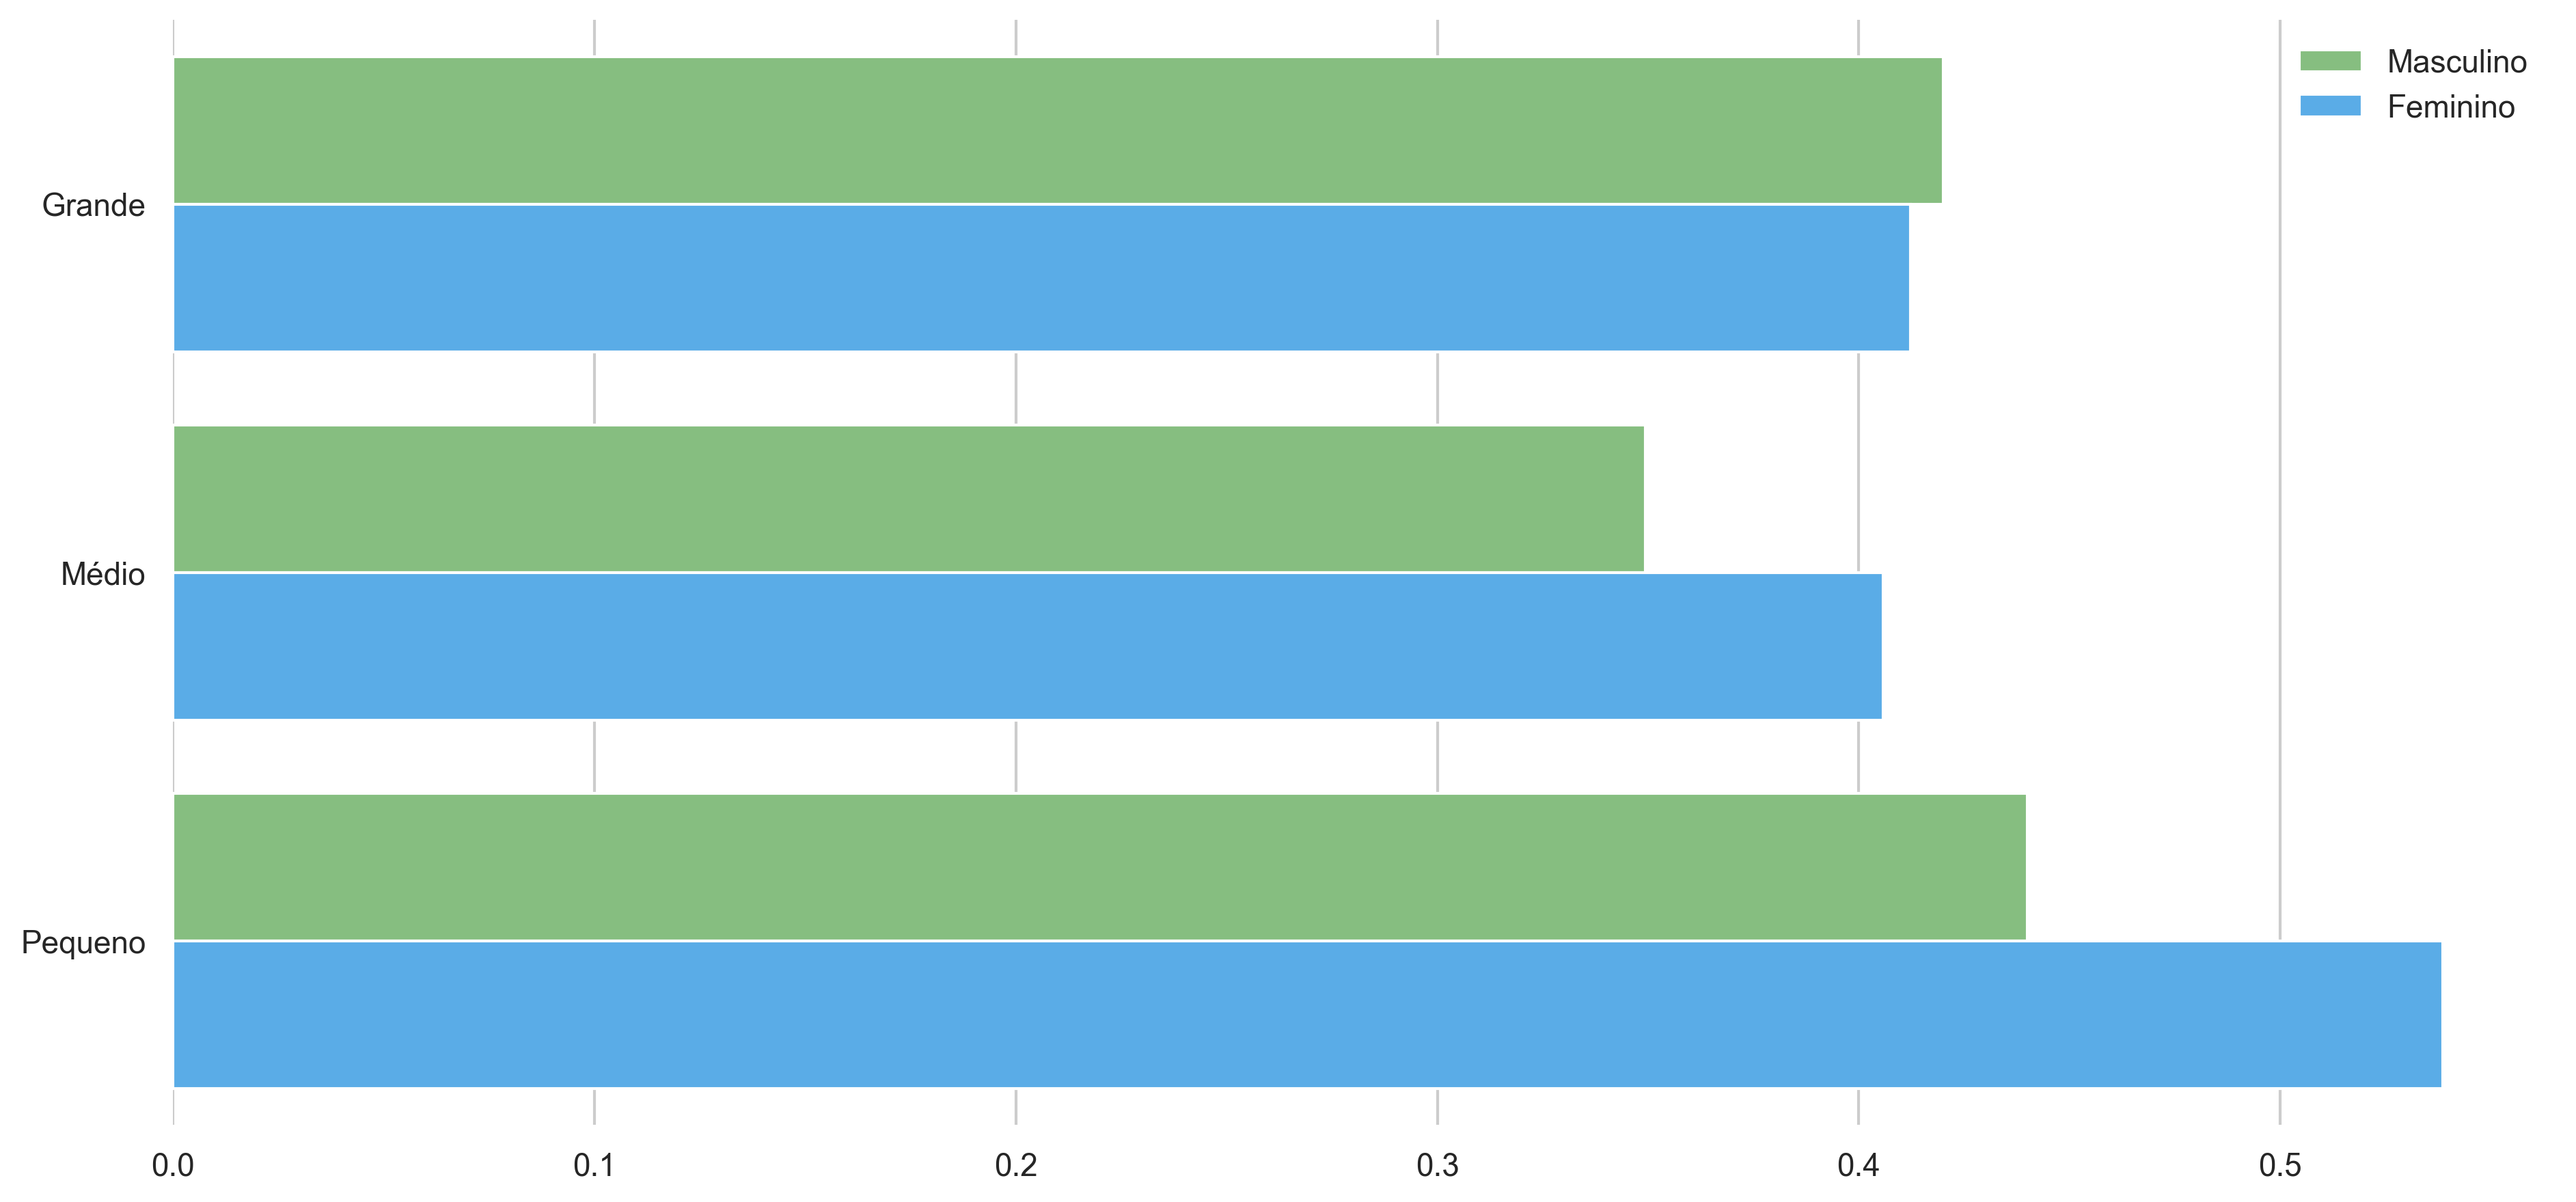

In [32]:
# Configurando o tema
sns.set_theme(style="whitegrid")

# Inicializando a figura do matplotlib
f, ax = plt.subplots(figsize=(15, 7), dpi=300)  # Ajuste o tamanho conforme necessário

sns.barplot(y = 'categoria_partido', x = 'score_final', data = indicadores, hue = "sexo", orient='h', 
            palette = dict(Masculino = "#7EC876", Feminino = "#42B0FF"),
            estimator = np.mean, ci = None)

# Adicionando a legenda e rótulos informativos aos eixos
ax.legend(ncol=1, loc="upper right", frameon=False)
ax.set(xlabel="",
       ylabel="")
sns.despine(left=True, bottom=True)
plt.ticklabel_format(style='plain', axis='x')

# Salvando o gráfico
plt.savefig("score_final_porte.svg", format='svg')
# Mostrando o gráfico
plt.show()

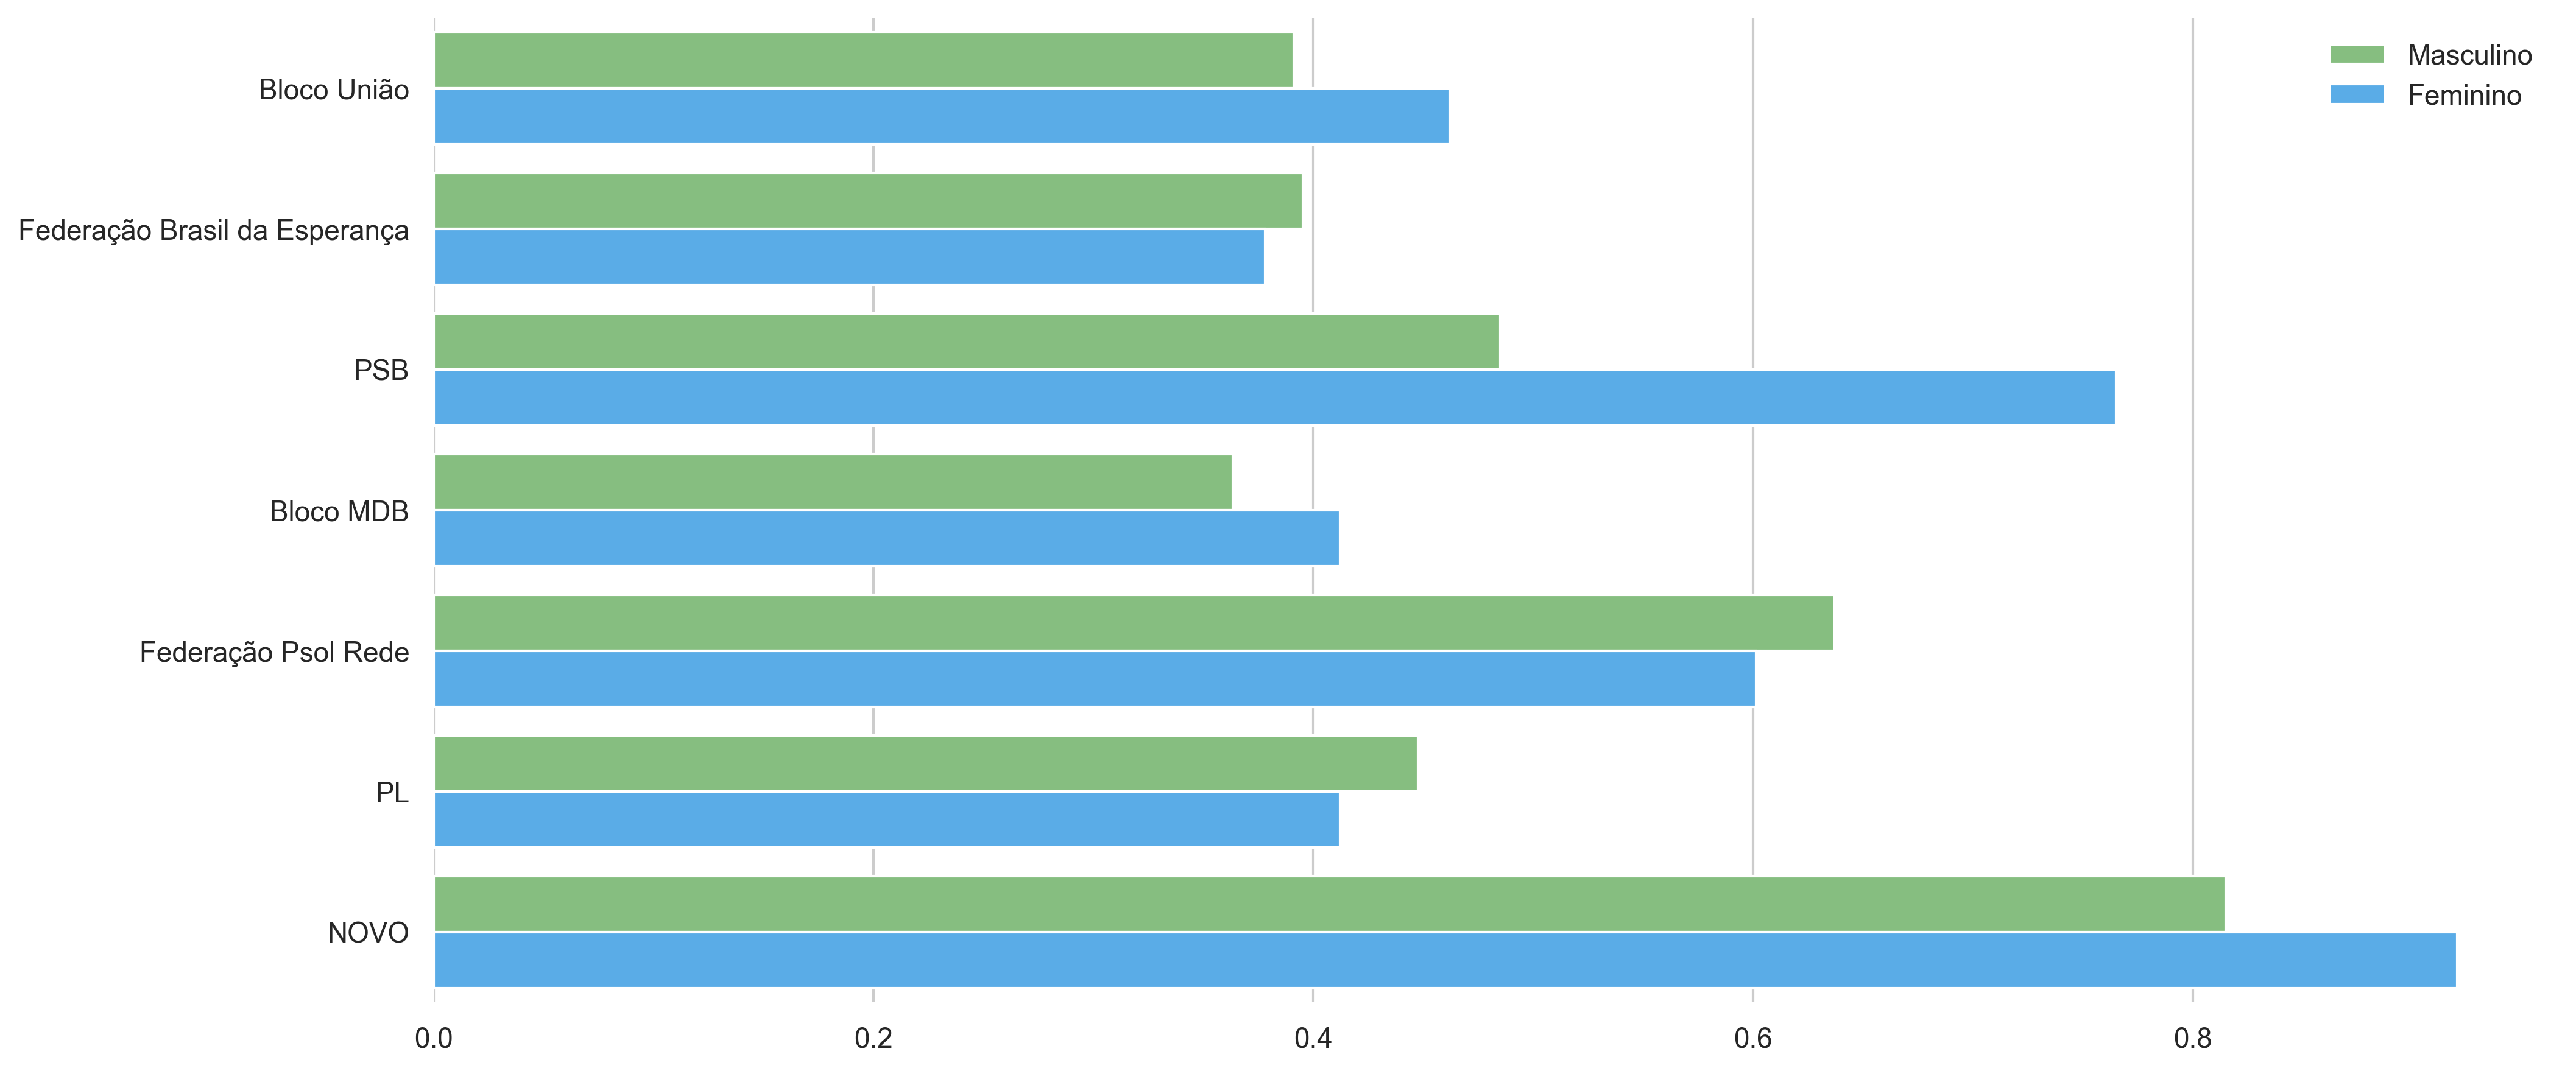

In [89]:
# Plot sem os sem partido
plot_bloco = indicadores.drop(indicadores[indicadores['bloco'] == 'Sem partido'].index)

# Configurando o tema
sns.set_theme(style="whitegrid")

# Inicializando a figura do matplotlib
f, ax = plt.subplots(figsize=(15, 7), dpi=300)  # Ajuste o tamanho conforme necessário

sns.barplot(y = 'bloco', x = 'score_final', data = plot_bloco, hue = "sexo", orient='h', 
            palette = dict(Masculino = "#7EC876", Feminino = "#42B0FF"),
            estimator = np.mean, ci = None)

# Adicionando a legenda e rótulos informativos aos eixos
ax.legend(ncol=1, loc="upper right", frameon=False)
ax.set(xlabel="",
       ylabel="")
sns.despine(left=True, bottom=True)
plt.ticklabel_format(style='plain', axis='x')

# Salvando o gráfico
plt.savefig("score_final_bloco.svg", format='svg')
# Mostrando o gráfico
plt.show()

### Com todos os scores de produção legislativa

- Gráfico radar por bloco e sexo

In [97]:
import plotly.graph_objects as go
import plotly.express as px

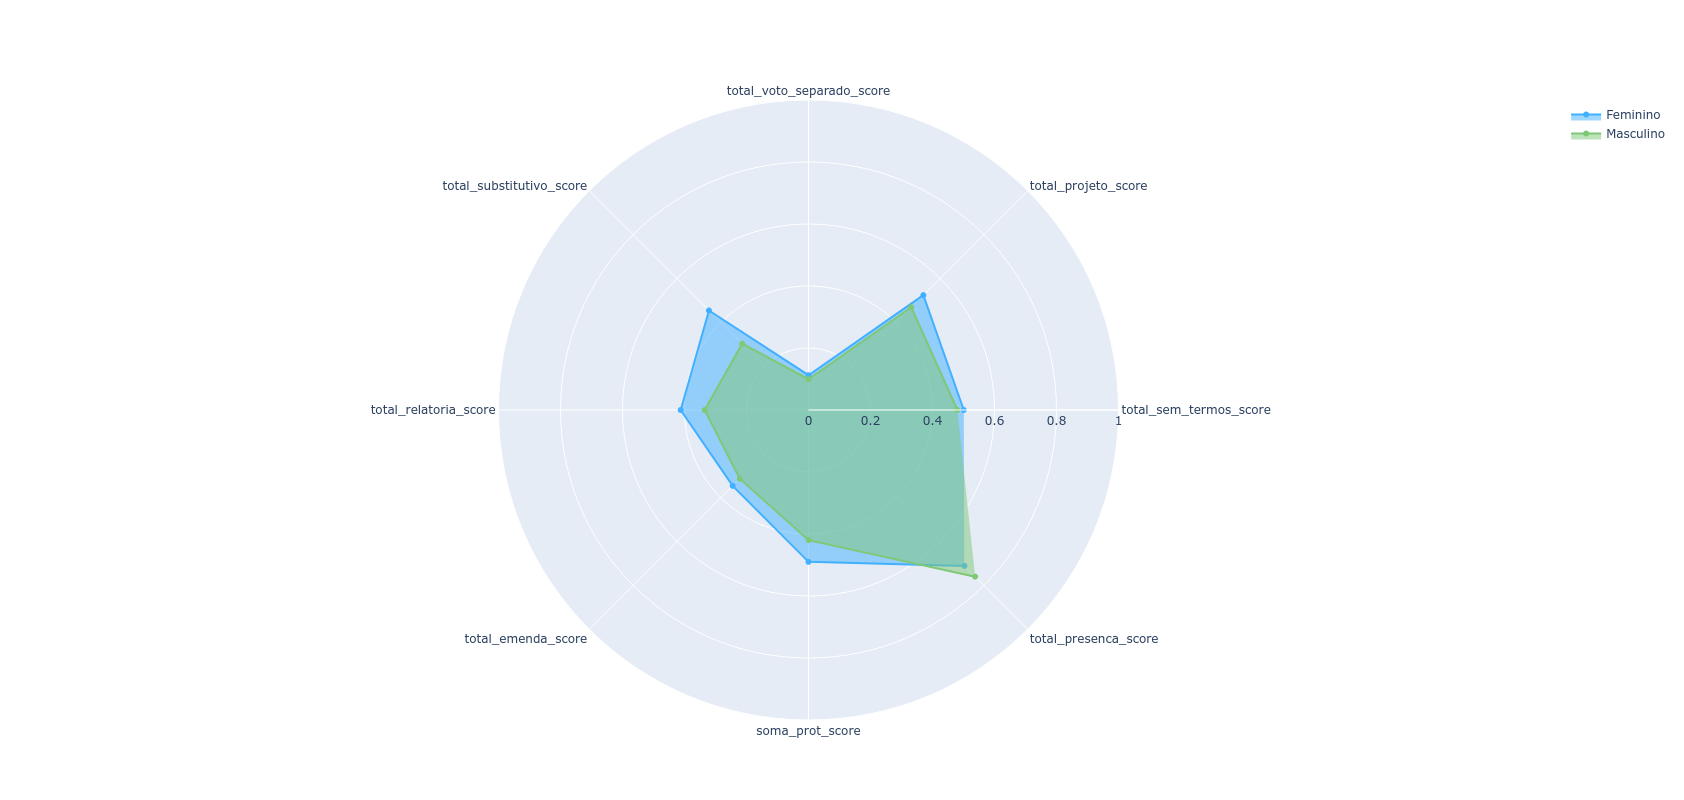

In [119]:
# Por sexo
sexo = indicadores.groupby(['sexo']).mean().reset_index()

categories = ['total_sem_termos_score','total_projeto_score','total_voto_separado_score','total_substitutivo_score','total_relatoria_score','total_emenda_score','soma_prot_score','total_presenca_score']

color_map = {
    'Masculino': '#7EC876',
    'Feminino': '#42B0FF'
}

fig = go.Figure()

# Adicionar traces ao gráfico para cada combinação de bloco e sexo
for (sexo), group in sexo.groupby(['sexo']):
    fig.add_trace(go.Scatterpolar(
        r=group[categories].values.flatten().tolist(),
        theta=categories,
        fill='toself',
        name=f'{sexo}',
        line_color=color_map[sexo],
    ))

# Customização do gráfico
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  # ajuste conforme necessário
        )),
    showlegend=True,
    width=1000,  # Largura da figura
    height=800  # Altura da figura
)

# Salvando o gráfico
fig.show()

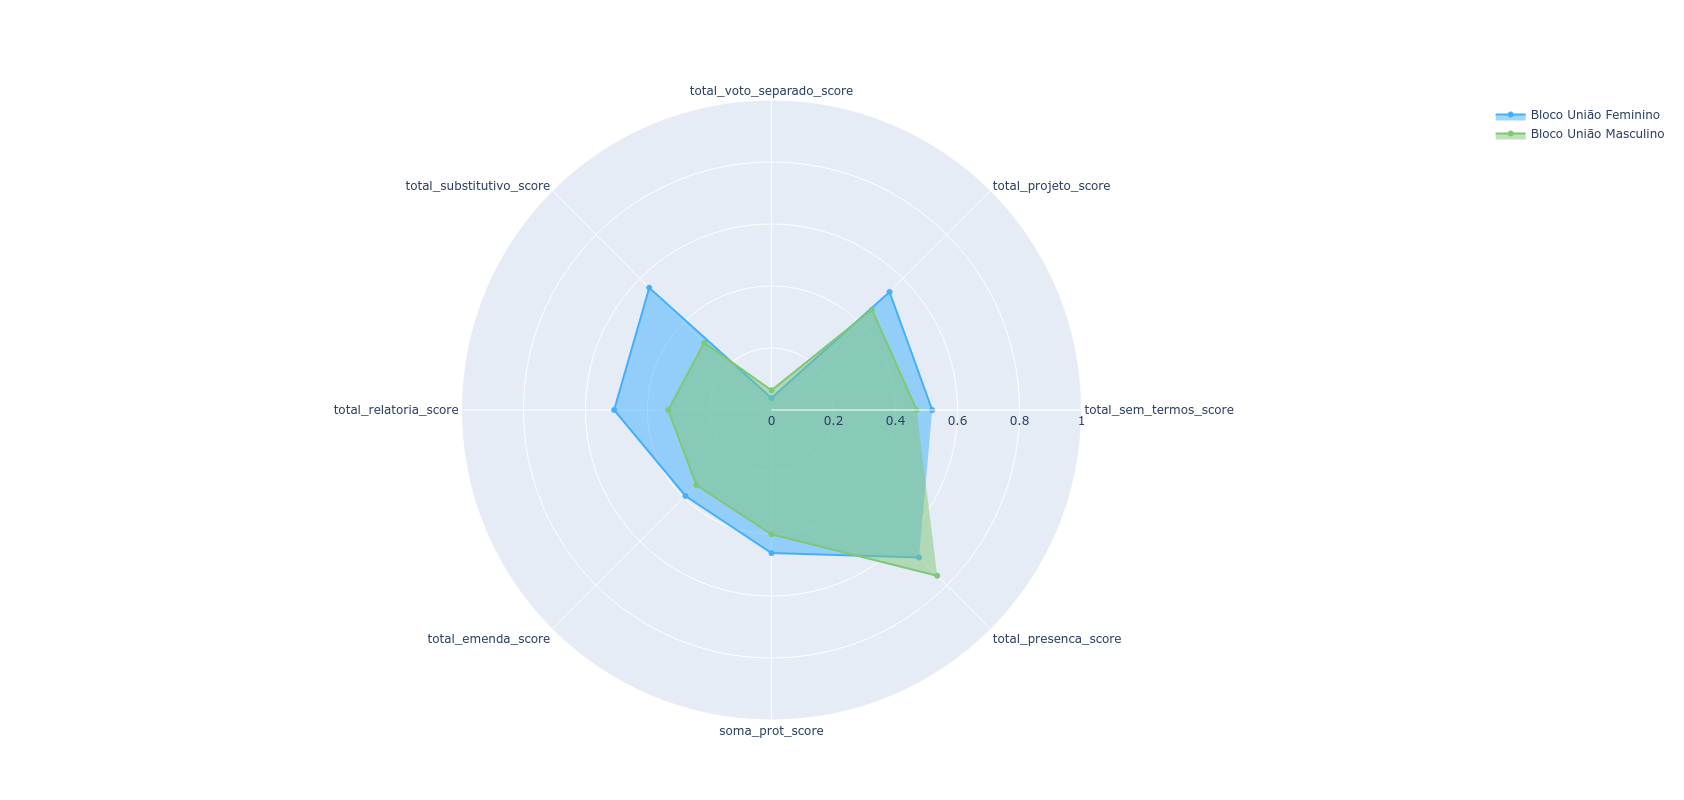

In [111]:
# Bloco União
bloco_uniao = indicadores[indicadores['bloco'] == 'Bloco União']
bloco_uniao_sexo = bloco_uniao.groupby(['sexo']).mean().reset_index()

categories = ['total_sem_termos_score','total_projeto_score','total_voto_separado_score','total_substitutivo_score','total_relatoria_score','total_emenda_score','soma_prot_score','total_presenca_score']

color_map = {
    'Masculino': '#7EC876',
    'Feminino': '#42B0FF'
}

fig = go.Figure()

# Adicionar traces ao gráfico para cada combinação de bloco e sexo
for (sexo), group in bloco_uniao_sexo.groupby(['sexo']):
    fig.add_trace(go.Scatterpolar(
        r=group[categories].values.flatten().tolist(),
        theta=categories,
        fill='toself',
        name=f'Bloco União {sexo}',
        line_color=color_map[sexo],
    ))

# Customização do gráfico
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  # ajuste conforme necessário
        )),
    showlegend=True,
    width=1000,  # Largura da figura
    height=800  # Altura da figura
)

# Salvando o gráfico
fig.show()

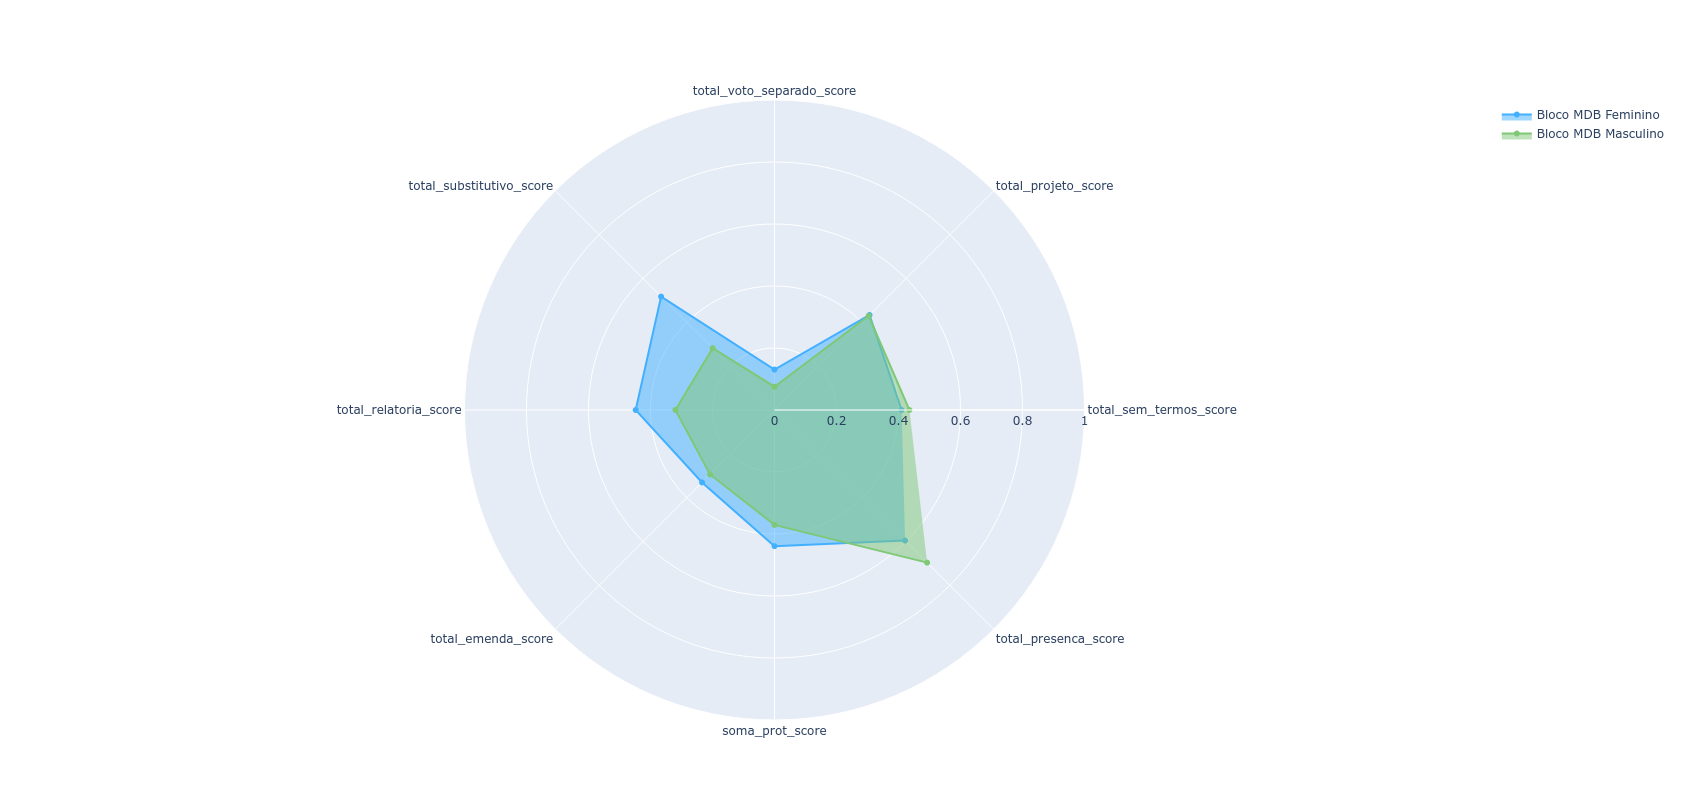

In [112]:
# Bloco MDB
bloco_mdb = indicadores[indicadores['bloco'] == 'Bloco MDB']
bloco_mdb_sexo = bloco_mdb.groupby(['sexo']).mean().reset_index()

categories = ['total_sem_termos_score','total_projeto_score','total_voto_separado_score','total_substitutivo_score','total_relatoria_score','total_emenda_score','soma_prot_score','total_presenca_score']

color_map = {
    'Masculino': '#7EC876',
    'Feminino': '#42B0FF'
}

fig = go.Figure()

# Adicionar traces ao gráfico para cada combinação de bloco e sexo
for (sexo), group in bloco_mdb_sexo.groupby(['sexo']):
    fig.add_trace(go.Scatterpolar(
        r=group[categories].values.flatten().tolist(),
        theta=categories,
        fill='toself',
        name=f'Bloco MDB {sexo}',
        line_color=color_map[sexo],
    ))

# Customização do gráfico
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  # ajuste conforme necessário
        )),
    showlegend=True,
    width=1000,  # Largura da figura
    height=800  # Altura da figura
)

# Salvando o gráfico
fig.show()

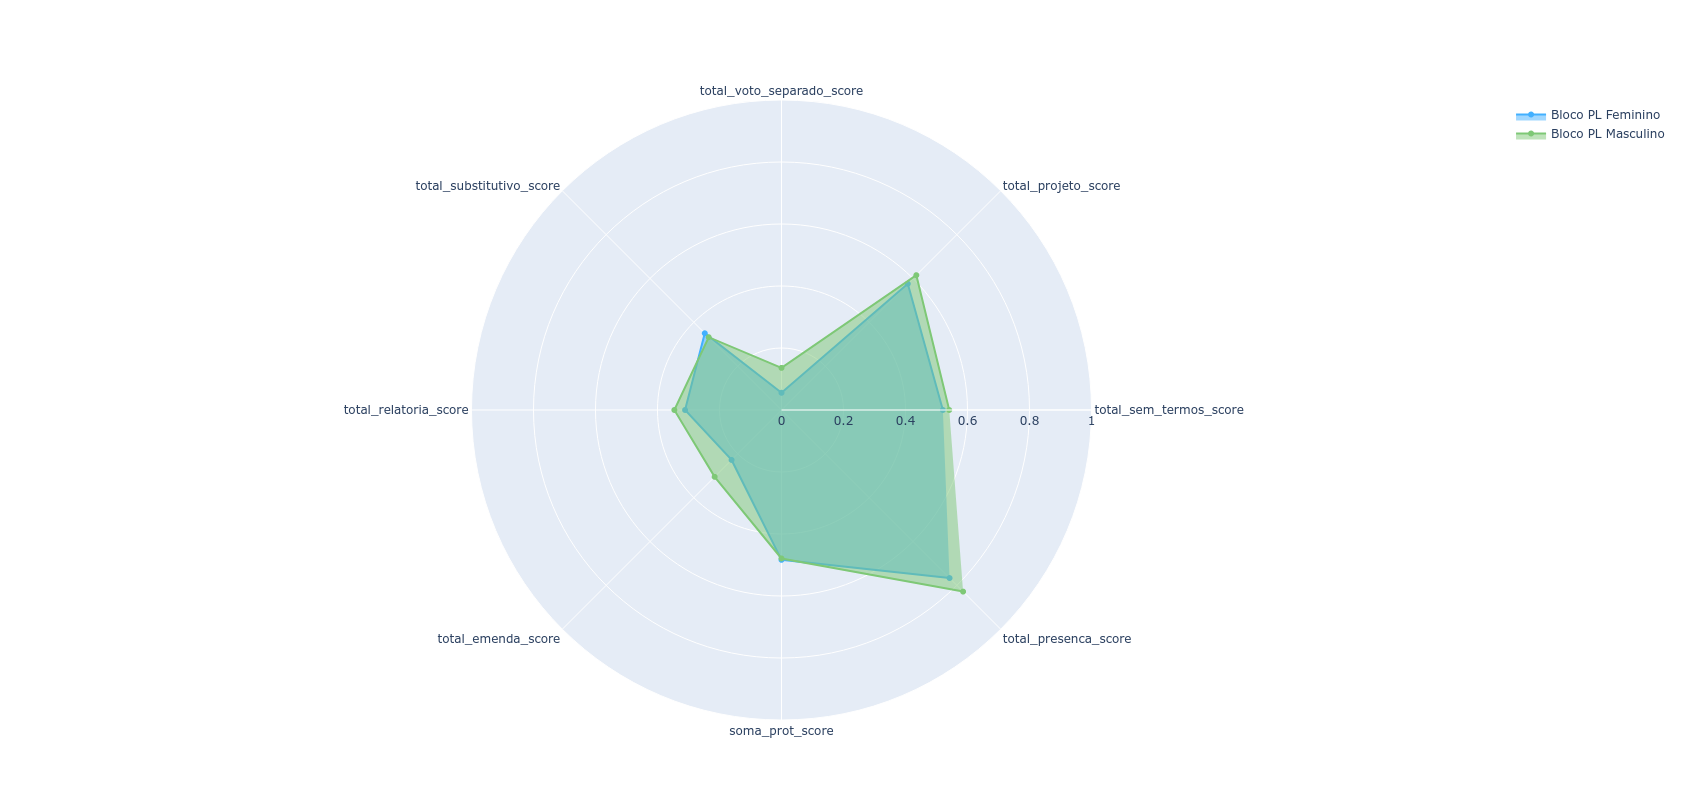

In [113]:
# Bloco PL
bloco_pl = indicadores[indicadores['bloco'] == 'PL']
bloco_pl_sexo = bloco_pl.groupby(['sexo']).mean().reset_index()

categories = ['total_sem_termos_score','total_projeto_score','total_voto_separado_score','total_substitutivo_score','total_relatoria_score','total_emenda_score','soma_prot_score','total_presenca_score']

color_map = {
    'Masculino': '#7EC876',
    'Feminino': '#42B0FF'
}

fig = go.Figure()

# Adicionar traces ao gráfico para cada combinação de bloco e sexo
for (sexo), group in bloco_pl_sexo.groupby(['sexo']):
    fig.add_trace(go.Scatterpolar(
        r=group[categories].values.flatten().tolist(),
        theta=categories,
        fill='toself',
        name=f'Bloco PL {sexo}',
        line_color=color_map[sexo],
    ))

# Customização do gráfico
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  # ajuste conforme necessário
        )),
    showlegend=True,
    width=1000,  # Largura da figura
    height=800  # Altura da figura
)

# Salvando o gráfico
fig.show()

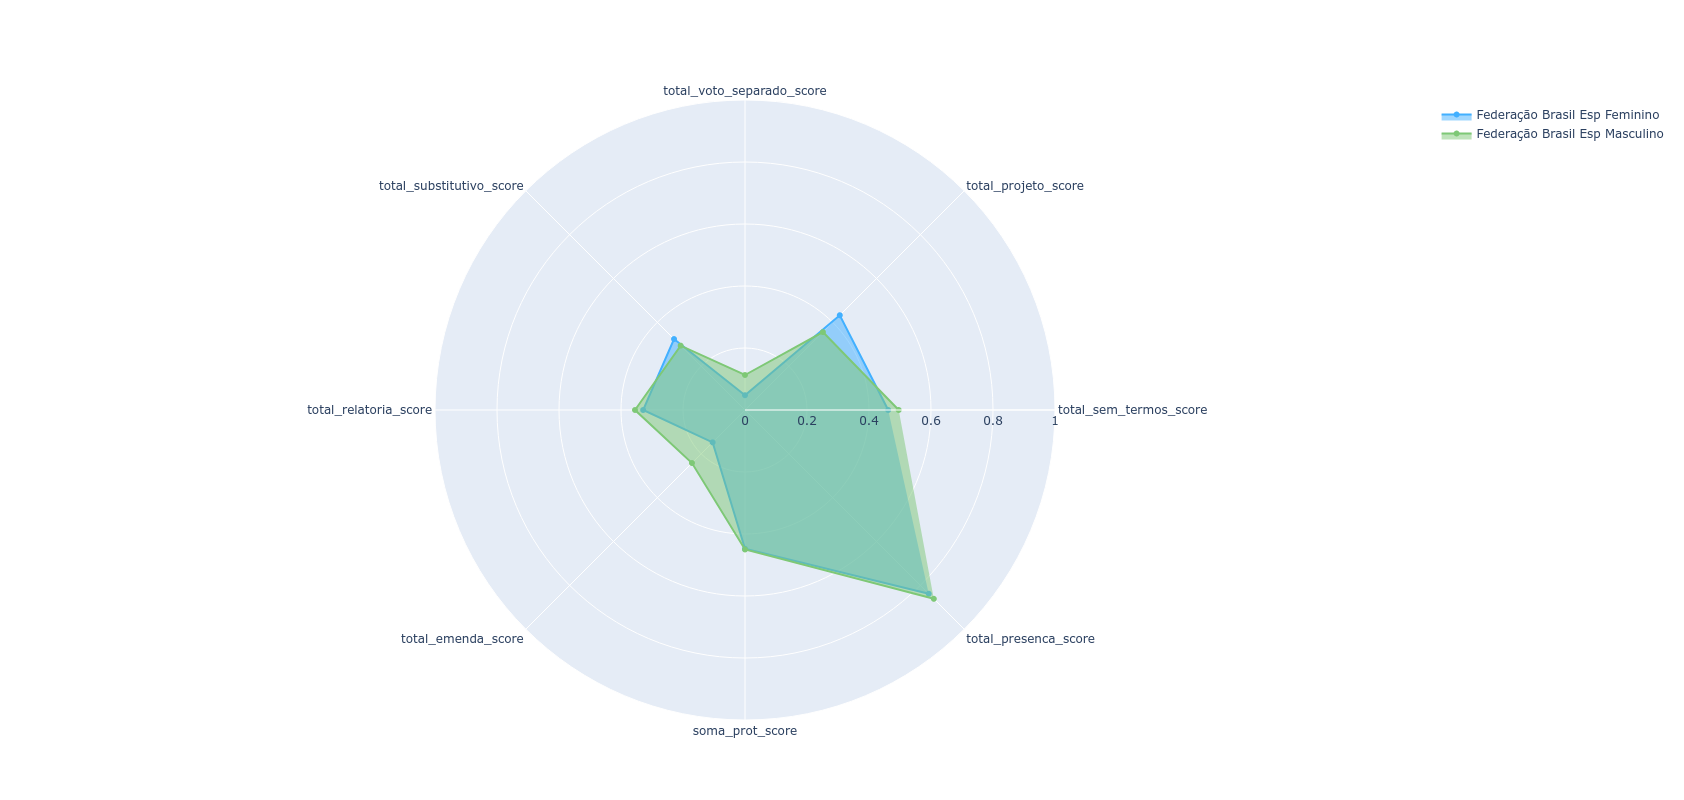

In [114]:
# Federação Brasil da Esperança
bloco_esperanca = indicadores[indicadores['bloco'] == 'Federação Brasil da Esperança']
bloco_esperanca_sexo = bloco_esperanca.groupby(['sexo']).mean().reset_index()

categories = ['total_sem_termos_score','total_projeto_score','total_voto_separado_score','total_substitutivo_score','total_relatoria_score','total_emenda_score','soma_prot_score','total_presenca_score']

color_map = {
    'Masculino': '#7EC876',
    'Feminino': '#42B0FF'
}

fig = go.Figure()

# Adicionar traces ao gráfico para cada combinação de bloco e sexo
for (sexo), group in bloco_esperanca_sexo.groupby(['sexo']):
    fig.add_trace(go.Scatterpolar(
        r=group[categories].values.flatten().tolist(),
        theta=categories,
        fill='toself',
        name=f'Federação Brasil Esp {sexo}',
        line_color=color_map[sexo],
    ))

# Customização do gráfico
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  # ajuste conforme necessário
        )),
    showlegend=True,
    width=1000,  # Largura da figura
    height=800  # Altura da figura
)

# Salvando o gráfico
fig.show()

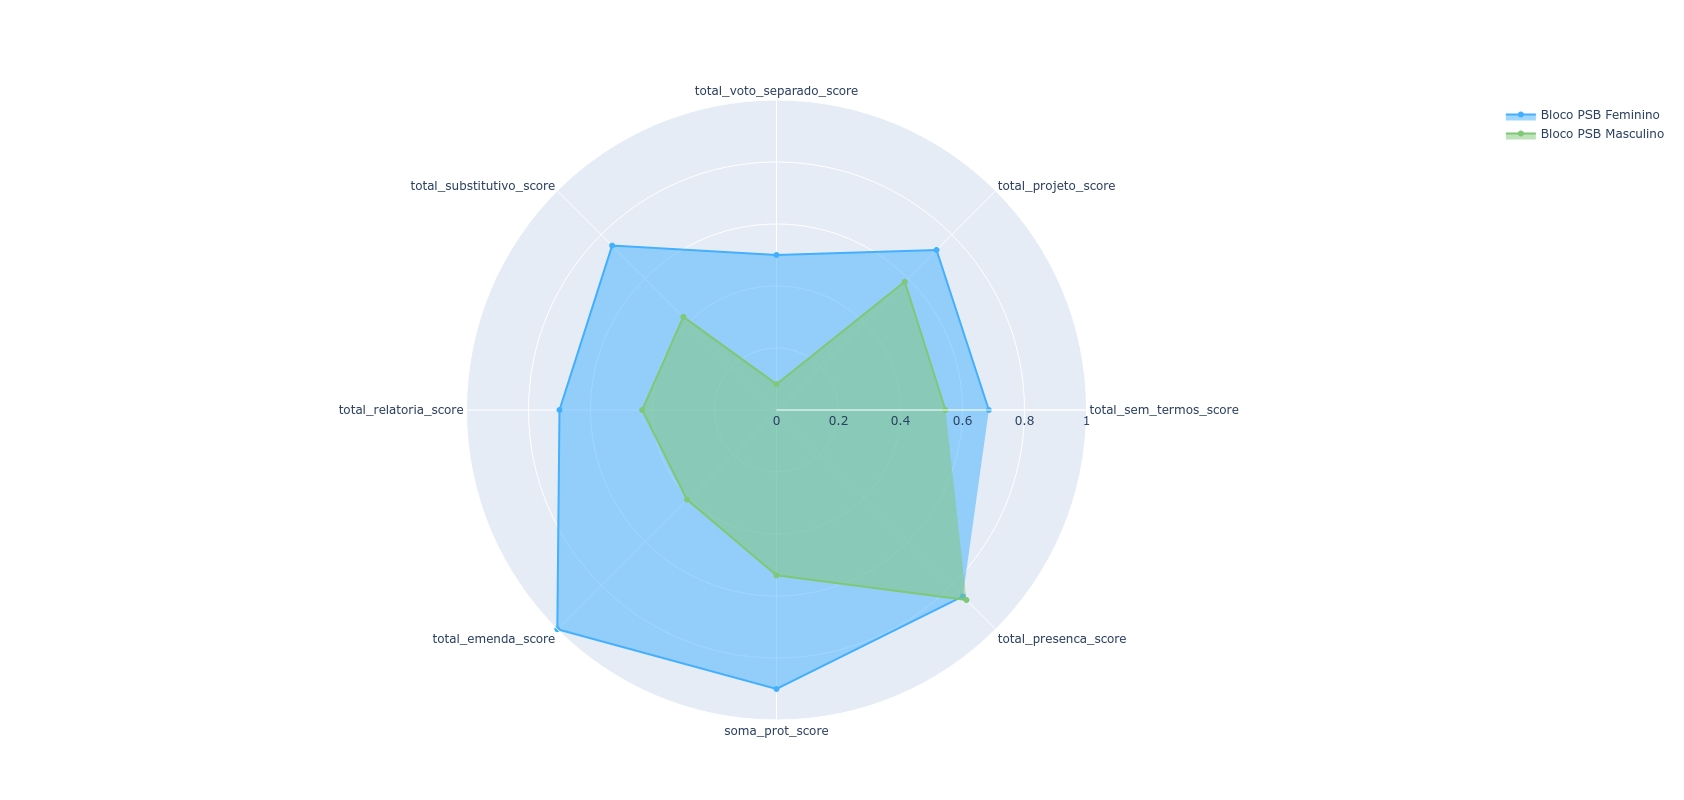

In [115]:
# Bloco PSB
bloco_psb = indicadores[indicadores['bloco'] == 'PSB']
bloco_psb_sexo = bloco_psb.groupby(['sexo']).mean().reset_index()

categories = ['total_sem_termos_score','total_projeto_score','total_voto_separado_score','total_substitutivo_score','total_relatoria_score','total_emenda_score','soma_prot_score','total_presenca_score']

color_map = {
    'Masculino': '#7EC876',
    'Feminino': '#42B0FF'
}

fig = go.Figure()

# Adicionar traces ao gráfico para cada combinação de bloco e sexo
for (sexo), group in bloco_psb_sexo.groupby(['sexo']):
    fig.add_trace(go.Scatterpolar(
        r=group[categories].values.flatten().tolist(),
        theta=categories,
        fill='toself',
        name=f'Bloco PSB {sexo}',
        line_color=color_map[sexo],
    ))

# Customização do gráfico
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  # ajuste conforme necessário
        )),
    showlegend=True,
    width=1000,  # Largura da figura
    height=800  # Altura da figura
)

# Salvando o gráfico
fig.show()

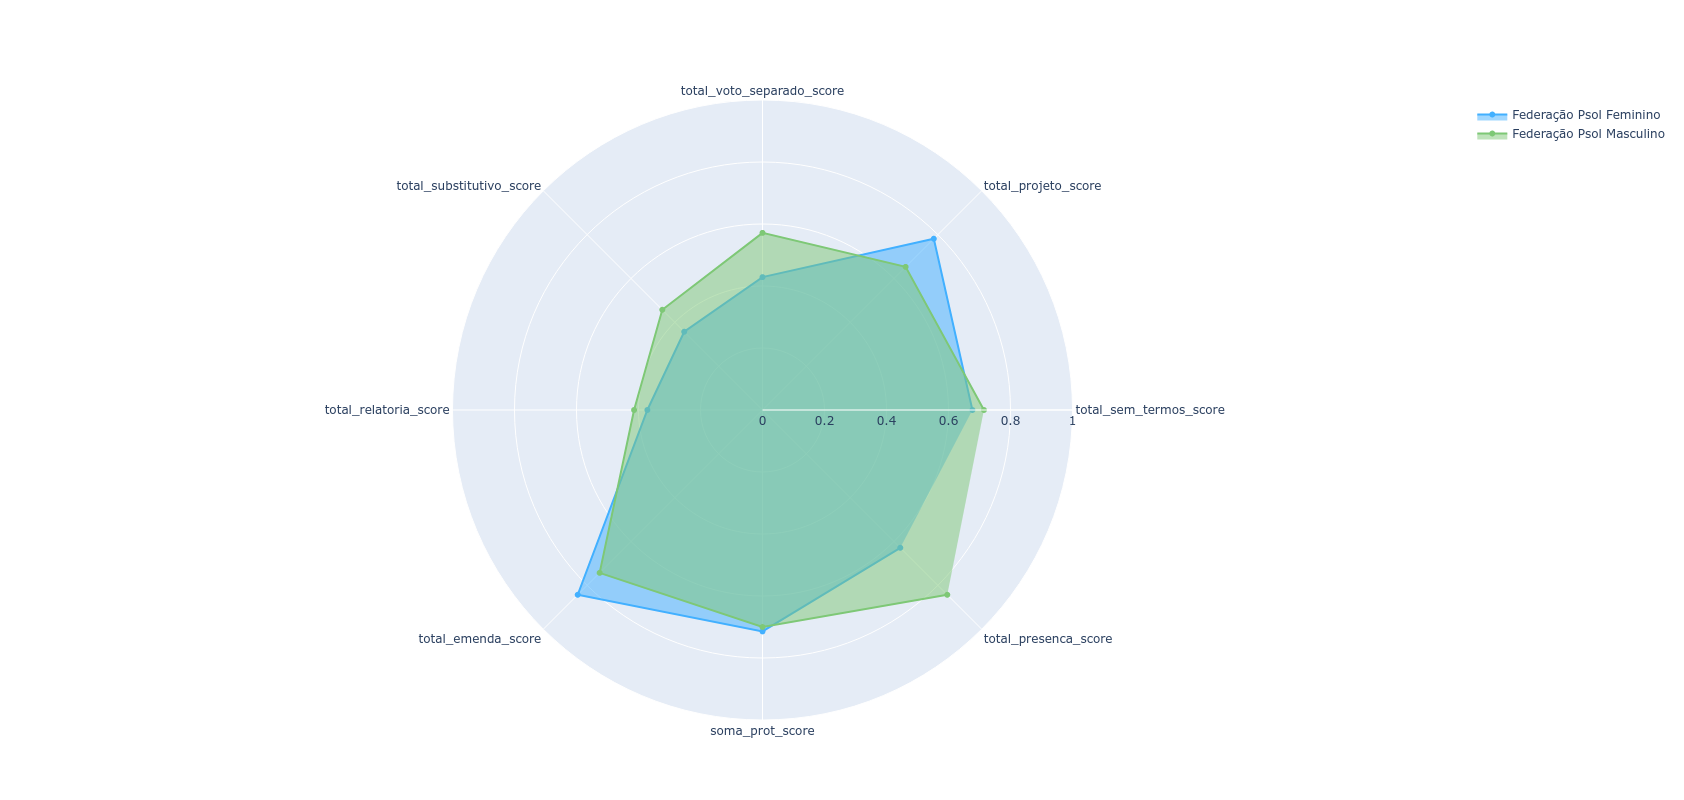

In [116]:
# Federação Psol Rede
bloco_psol = indicadores[indicadores['bloco'] == 'Federação Psol Rede']
bloco_psol_sexo = bloco_psol.groupby(['sexo']).mean().reset_index()

categories = ['total_sem_termos_score','total_projeto_score','total_voto_separado_score','total_substitutivo_score','total_relatoria_score','total_emenda_score','soma_prot_score','total_presenca_score']

color_map = {
    'Masculino': '#7EC876',
    'Feminino': '#42B0FF'
}

fig = go.Figure()

# Adicionar traces ao gráfico para cada combinação de bloco e sexo
for (sexo), group in bloco_psol_sexo.groupby(['sexo']):
    fig.add_trace(go.Scatterpolar(
        r=group[categories].values.flatten().tolist(),
        theta=categories,
        fill='toself',
        name=f'Federação Psol {sexo}',
        line_color=color_map[sexo],
    ))

# Customização do gráfico
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  # ajuste conforme necessário
        )),
    showlegend=True,
    width=1000,  # Largura da figura
    height=800  # Altura da figura
)

# Salvando o gráfico
fig.show()

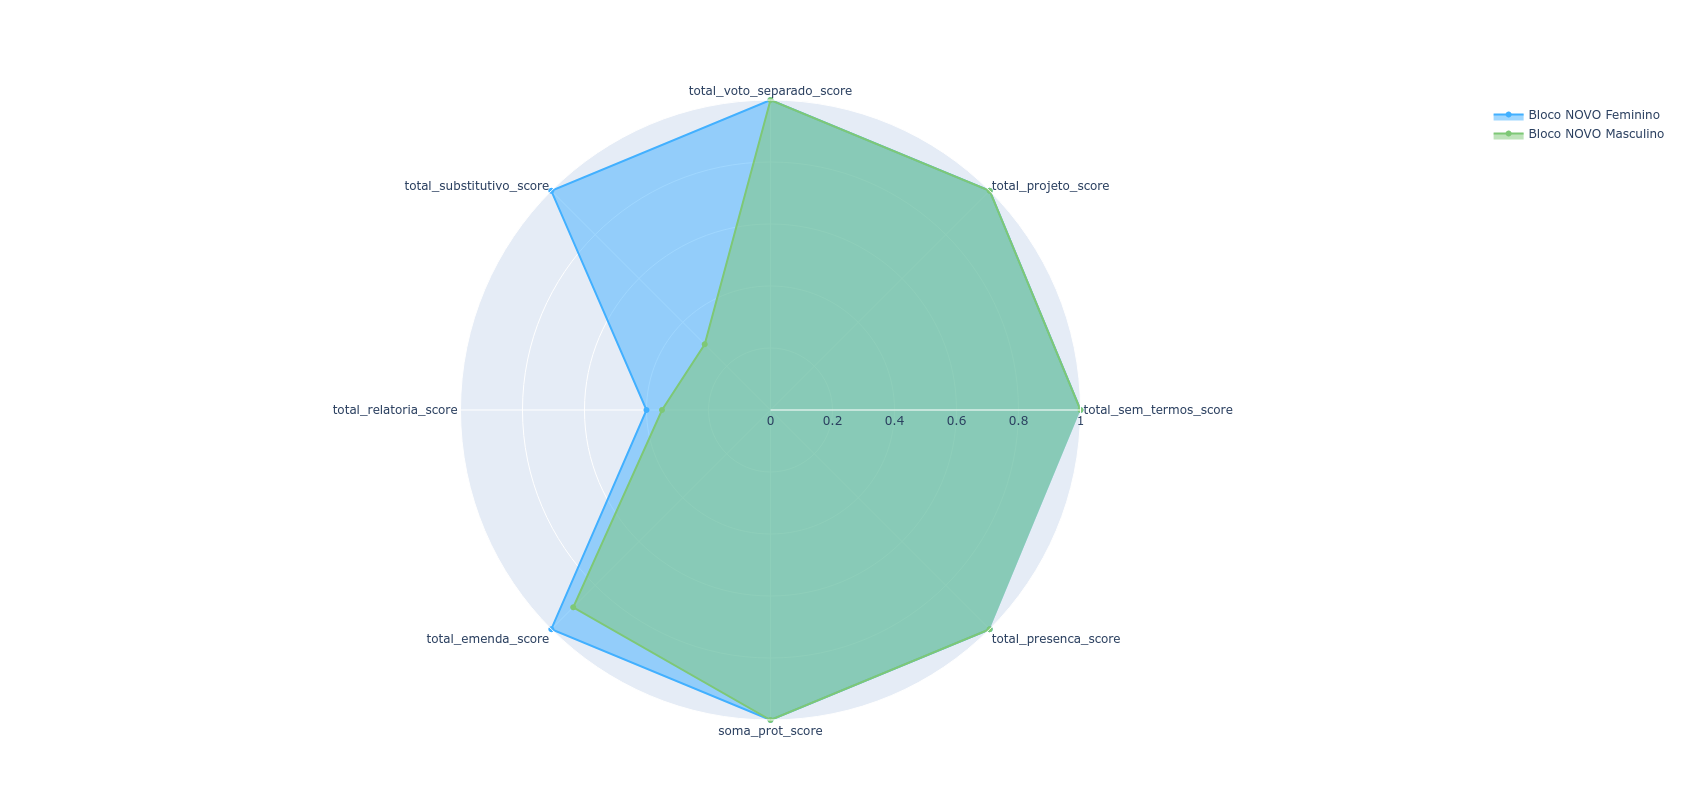

In [117]:
# Novo
bloco_novo = indicadores[indicadores['bloco'] == 'NOVO']
bloco_novo_sexo = bloco_novo.groupby(['sexo']).mean().reset_index()

categories = ['total_sem_termos_score','total_projeto_score','total_voto_separado_score','total_substitutivo_score','total_relatoria_score','total_emenda_score','soma_prot_score','total_presenca_score']

color_map = {
    'Masculino': '#7EC876',
    'Feminino': '#42B0FF'
}

fig = go.Figure()

# Adicionar traces ao gráfico para cada combinação de bloco e sexo
for (sexo), group in bloco_novo_sexo.groupby(['sexo']):
    fig.add_trace(go.Scatterpolar(
        r=group[categories].values.flatten().tolist(),
        theta=categories,
        fill='toself',
        name=f'Bloco NOVO {sexo}',
        line_color=color_map[sexo],
    ))

# Customização do gráfico
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  # ajuste conforme necessário
        )),
    showlegend=True,
    width=1000,  # Largura da figura
    height=800  # Altura da figura
)

# Salvando o gráfico
fig.show()